In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import scipy.stats as stats
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import locale


In [3]:
df_price = (
    pd.read_excel("./../../data/Preise.xlsx") #./../../data/Preise.xlsx   - Pfad für Sandbox
        .rename(columns={"Jahr": "year",
                         "preis": "price"})
        .assign(year=lambda _data: pd.to_numeric(_data["year"].str.strip('"')))
        .replace([20022, "Tablet Basics"],[2022, "Tablet Basic"])
)

In [4]:
df_crm = (
    pd.read_excel("./../../data/CRM_data.xlsx")
        .rename(columns={"id": "transaction_id",
                         "vorname": "firstname",
                         "nachname": "lastname"})
)

In [5]:
def read_regio_data(region, kind): 
    return (pd.read_excel(f"./../../data/Region{region}_{kind}.xlsx")
                .rename(columns={"Tablet Basic": "basic",
                                "Tablet Mini": "mini",
                                "Tablet Pro": "pro",
                                "kosten_mini": "cost_mini",
                                "kosten_basic": "cost_basic",
                                "kosten_pro": "cost_pro",
                                "PRODUKT": "product"})
                .assign(year=lambda _data: _data["date"].dt.year,
                        month=lambda _data: _data["date"].dt.month,
                        week=lambda _data: _data["date"].dt.isocalendar().week,
                        cost_basic=lambda _data: np.round(_data["cost_basic"], 2),
                        cost_mini=lambda _data: np.round(_data["cost_mini"], 2),
                        cost_pro=lambda _data: np.round(_data["cost_pro"], 2),
                        cost_per_unit=lambda _data: _data["cost_basic"].fillna(0) + _data["cost_mini"].fillna(0) + _data["cost_pro"].fillna(0),
                        cost=lambda _data: _data["cost_per_unit"] * _data["amount"]
                        )
                .merge(df_price, on=["year", "product"])
                .assign(revenue=lambda _data: _data["price"] * _data["amount"],
                        profit_per_unit=lambda _data: _data["price"] - _data["cost_per_unit"],
                        profit=lambda _data: _data["profit_per_unit"] * _data["amount"])
                .merge(df_crm[["customer_rating", "transaction_id"]], on="transaction_id"))

df_regAo = read_regio_data("A","online")
df_regAp = read_regio_data("A","phone")
df_regAs = read_regio_data("A","store")
df_regBo = read_regio_data("B","online")
df_regBp = read_regio_data("B","phone")
df_regBs = read_regio_data("B","store")
df_regCo = read_regio_data("C","online")
df_regCp = read_regio_data("C","phone")
df_regCs = read_regio_data("C","store")
df_regDo = read_regio_data("D","online")
df_regDp = read_regio_data("D","phone")
df_regDs = read_regio_data("D","store")

In [6]:
# Array mit Zuordnung der DataFrames zu Region und Marketplace
dataframes = [
    (df_regAo, 'A', 'online'),
    (df_regAp, 'A', 'phone'),
    (df_regAs, 'A', 'store'),
    (df_regBo, 'B', 'online'),
    (df_regBp, 'B', 'phone'),
    (df_regBs, 'B', 'store'),
    (df_regCo, 'C', 'online'),
    (df_regCp, 'C', 'phone'),
    (df_regCs, 'C', 'store'),
    (df_regDo, 'D', 'online'),
    (df_regDp, 'D', 'phone'),
    (df_regDs, 'D', 'store')
]

# Spezifische Region und Marktplatz zu jedem Frame hinzufügen
for df_reg_main, region, marketplace in dataframes:
    df_reg_main['region'] = region
    df_reg_main['marketplace'] = marketplace

# Alle DataFrames zusammenfügen (concat)
# ignore_index=True: Index wird neu erstellt
df_reg_main = pd.concat([df for df, _, _ in dataframes], ignore_index=True)

In [7]:
# Create a custom formatter function for the y-axis
def millions_formatter(x, pos):
    return "%1.f Mio." % (x * 1e-6)

# Generic formatting for lineplot
def format_lineplot():
    # Define the plot size
    # plt.figure(figsize=(10, 6))

    # Set the locale to German to ensure month names are in German
    locale.setlocale(locale.LC_TIME, "de_DE.utf8")

    # Create a MonthLocator object to ensure ticks are set at monthly intervals
    locator = mdates.MonthLocator()

    # Set the locator for the x-axis
    plt.gca().xaxis.set_major_locator(locator)

    # Format x-axis with German months in abbreviated form and year
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))

    # Optionally, set the x-tick labels rotation
    plt.xticks(rotation=45)

    # Set the starting point of the y-axis to 0
    plt.gca().set_ylim(bottom=0)
    
    # Remove the y-axis and x-axis label
    plt.gca().set_ylabel("")
    plt.gca().set_xlabel("")

    # Add grid lines for better readability
    plt.grid(which="both", axis="both", linestyle="--", linewidth=0.5)

In [8]:
df_reg_main

,date,product,discount,amount,basic,mini,pro,cost_basic,cost_mini,cost_pro,...,week,cost_per_unit,cost,price,revenue,profit_per_unit,profit,customer_rating,region,marketplace
0,2021-11-01,Tablet Basic,1.0,5,1,0,0,170.02,NaN,NaN,...,44,170.02,850.10,529,2645,358.98,1794.90,7.1,A,online
1,2021-11-01,Tablet Basic,1.0,7,1,0,0,170.02,NaN,NaN,...,44,170.02,1190.14,529,3703,358.98,2512.86,5.9,A,online
2,2021-11-01,Tablet Basic,0.9,7,1,0,0,210.03,NaN,NaN,...,44,210.03,1470.21,529,3703,318.97,2232.79,7.5,A,online
3,2021-11-01,Tablet Basic,1.0,10,1,0,0,170.08,NaN,NaN,...,44,170.08,1700.80,529,5290,358.92,3589.20,6.6,A,online
4,2021-11-01,Tablet Basic,1.0,4,1,0,0,170.09,NaN,NaN,...,44,170.09,680.36,529,2116,358.91,1435.64,7.3,A,online
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335248,2022-10-31,Tablet Mini,1.0,4,0,1,0,NaN,247.07,NaN,...,44,247.07,988.28,550,2200,302.93,1211.72,9.1,D,store
335249,2022-10-31,Tablet Mini,1.0,1,0,1,0,NaN,246.07,NaN,...,44,246.07,246.07,550,550,303.93,303.93,7.1,D,store
335250,2022-10-31,Tablet Mini,1.0,2,0,1,0,NaN,246.05,NaN,...,44,246.05,492.10,550,1100,303.95,607.90,5.5,D,store
335251,2022-10-31,Tablet Mini,1.0,2,0,1,0,NaN,246.05,NaN,...,44,246.05,492.10,550,1100,303.95,607.90,6.2,D,store


In [9]:
df_basic = df_reg_main[df_reg_main["product"] == "Tablet Basic"]
df_mini = df_reg_main[df_reg_main["product"] == "Tablet Mini"]
df_pro = df_reg_main[df_reg_main["product"] == "Tablet Pro"]

df_basic

,date,product,discount,amount,basic,mini,pro,cost_basic,cost_mini,cost_pro,...,week,cost_per_unit,cost,price,revenue,profit_per_unit,profit,customer_rating,region,marketplace
0,2021-11-01,Tablet Basic,1.0,5,1,0,0,170.02,NaN,NaN,...,44,170.02,850.10,529,2645,358.98,1794.90,7.1,A,online
1,2021-11-01,Tablet Basic,1.0,7,1,0,0,170.02,NaN,NaN,...,44,170.02,1190.14,529,3703,358.98,2512.86,5.9,A,online
2,2021-11-01,Tablet Basic,0.9,7,1,0,0,210.03,NaN,NaN,...,44,210.03,1470.21,529,3703,318.97,2232.79,7.5,A,online
3,2021-11-01,Tablet Basic,1.0,10,1,0,0,170.08,NaN,NaN,...,44,170.08,1700.80,529,5290,358.92,3589.20,6.6,A,online
4,2021-11-01,Tablet Basic,1.0,4,1,0,0,170.09,NaN,NaN,...,44,170.09,680.36,529,2116,358.91,1435.64,7.3,A,online
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292429,2022-10-27,Tablet Basic,0.9,3,1,0,0,535.74,NaN,NaN,...,43,535.74,1607.22,499,1497,-36.74,-110.22,4.4,D,store
292430,2022-10-27,Tablet Basic,0.9,7,1,0,0,655.75,NaN,NaN,...,43,655.75,4590.25,499,3493,-156.75,-1097.25,2.9,D,store
292431,2022-10-29,Tablet Basic,1.0,1,1,0,0,537.91,NaN,NaN,...,43,537.91,537.91,499,499,-38.91,-38.91,4.2,D,store
292432,2022-10-29,Tablet Basic,1.0,1,1,0,0,537.93,NaN,NaN,...,43,537.93,537.93,499,499,-38.93,-38.93,4.9,D,store


In [10]:
stats_per_month = df_basic.groupby(pd.Grouper(key="date",freq="1M")).agg({"transaction_id": "count", "price": "mean", "cost_per_unit": "mean", "profit_per_unit": "mean", "revenue": "mean", "amount": "mean"})
stats_per_week = df_basic.groupby(pd.Grouper(key="date",freq="1W")).agg({"transaction_id": "count", "price": "mean", "cost_per_unit": "mean", "profit_per_unit": "mean", "revenue": "mean", "profit": "mean", "amount": "mean"})
stats_per_month

,transaction_id,price,cost_per_unit,profit_per_unit,revenue,amount
date,,,,,,
2021-11-30,10759,529.0,200.830756,328.169244,1496.874802,2.829631
2021-12-31,10417,529.0,222.049048,306.950952,1505.240376,2.845445
2022-01-31,9325,499.0,243.053416,255.946584,1386.444075,2.778445
2022-02-28,7920,499.0,263.356908,235.643092,1408.729924,2.823106
2022-03-31,7667,499.0,285.830811,213.169189,1427.945741,2.861615
2022-04-30,6642,499.0,307.756781,191.243219,1379.049082,2.763625
2022-05-31,6114,499.0,332.284848,166.715152,1418.811907,2.843310
2022-06-30,4856,499.0,354.196365,144.803635,1393.212932,2.792010
2022-07-31,4227,499.0,380.369250,118.630750,1387.921221,2.781405


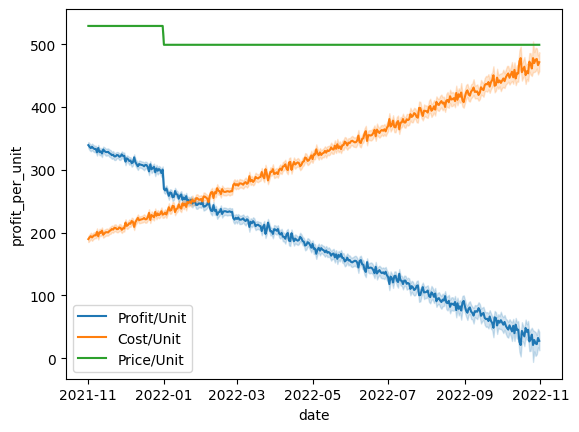

In [11]:
sns.lineplot(data=df_basic, x="date", y="profit_per_unit", label="Profit/Unit")
sns.lineplot(data=df_basic, x="date", y="cost_per_unit", label="Cost/Unit")
sns.lineplot(data=df_basic, x="date", y="price", label="Price/Unit")

plt.show()

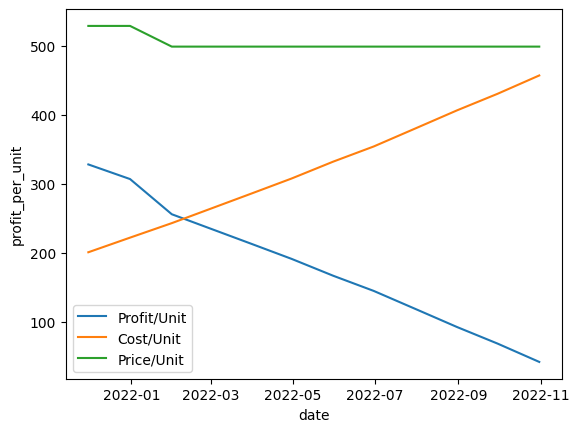

In [12]:
sns.lineplot(data=stats_per_month, x="date", y="profit_per_unit", label="Profit/Unit")
sns.lineplot(data=stats_per_month, x="date", y="cost_per_unit", label="Cost/Unit")
sns.lineplot(data=stats_per_month, x="date", y="price", label="Price/Unit")

plt.show()

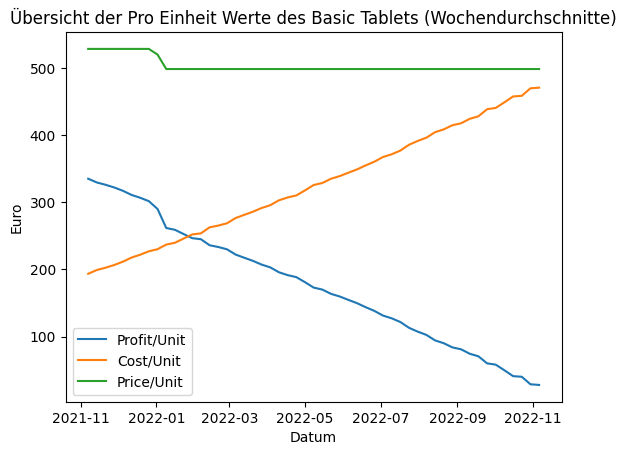

In [13]:
ax = sns.lineplot(data=stats_per_week, x="date", y="profit_per_unit", label="Profit/Unit")
sns.lineplot(data=stats_per_week, x="date", y="cost_per_unit", label="Cost/Unit")
sns.lineplot(data=stats_per_week, x="date", y="price", label="Price/Unit")

ax.set(title="Übersicht der Pro Einheit Werte des Basic Tablets (Wochendurchschnitte)", xlabel="Datum", ylabel="Euro")

plt.show()

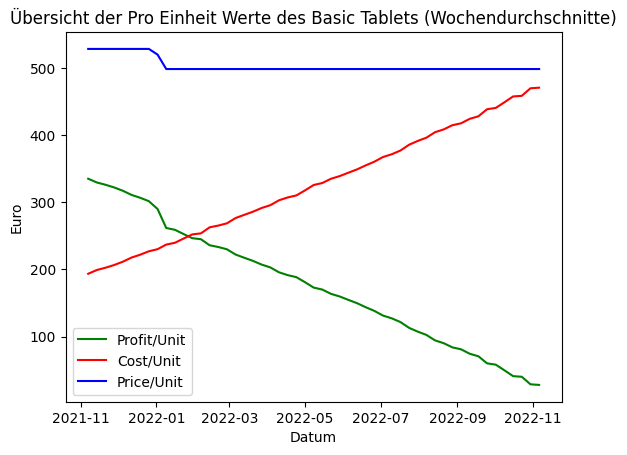

In [14]:
ax = sns.lineplot(data=stats_per_week, x="date", y="profit_per_unit", label="Profit/Unit", color="green")
sns.lineplot(data=stats_per_week, x="date", y="cost_per_unit", label="Cost/Unit", color="red")
sns.lineplot(data=stats_per_week, x="date", y="price", label="Price/Unit", color="blue")

ax.set(title="Übersicht der Pro Einheit Werte des Basic Tablets (Wochendurchschnitte)", xlabel="Datum", ylabel="Euro")

plt.show()

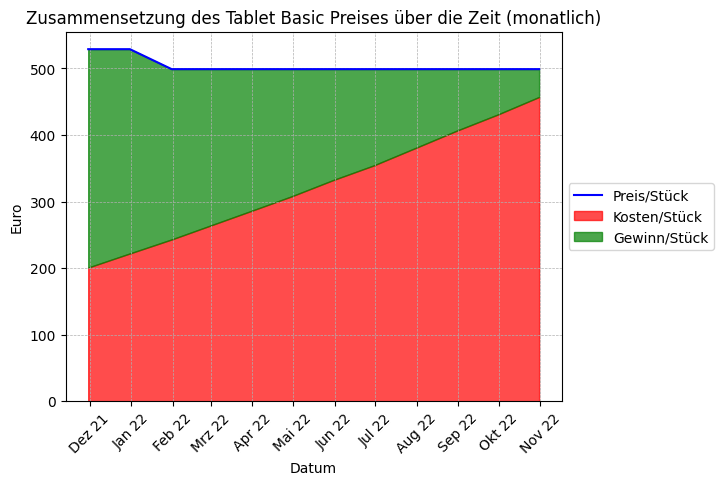

In [15]:
stats_per_week_res = stats_per_month.reset_index()

#plt.figure(figsize=(10, 6))


ax = sns.lineplot(x='date', y='price', data=stats_per_week_res, label='Preis/Stück', color='blue')
plt.fill_between(stats_per_week_res['date'], 0, stats_per_week_res['cost_per_unit'], label='Kosten/Stück', color='red', alpha=0.7)
plt.fill_between(stats_per_week_res['date'], stats_per_week_res['cost_per_unit'], stats_per_week_res['cost_per_unit'] + stats_per_week_res['profit_per_unit'], label='Gewinn/Stück', color='green', alpha=0.7)
format_lineplot()



ax.set(title="Zusammensetzung des Tablet Basic Preises über die Zeit (monatlich)", xlabel="Datum", ylabel="Euro")
plt.xticks(rotation=45)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()



In [16]:

sum_stats_per_week = df_basic.groupby(pd.Grouper(key="date",freq="1M")).agg({"transaction_id": "count", "price": "mean", "revenue": "sum", "profit": "sum", "amount": "sum", "cost": "sum", "customer_rating": "mean"})


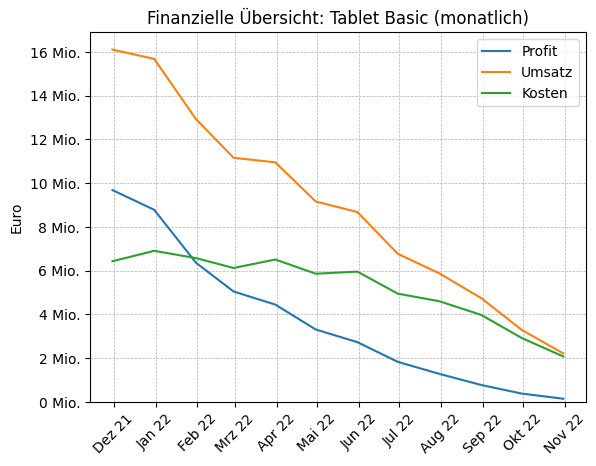

In [17]:
sns.lineplot(data=sum_stats_per_week, x="date", y="profit", label="Profit")
sns.lineplot(data=sum_stats_per_week, x="date", y="revenue", label="Umsatz")
sns.lineplot(data=sum_stats_per_week, x="date", y="cost", label="Kosten")

format_lineplot()
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))
plt.title("Finanzielle Übersicht: Tablet Basic (monatlich)")
plt.gca().set_ylabel("Euro")

plt.show()

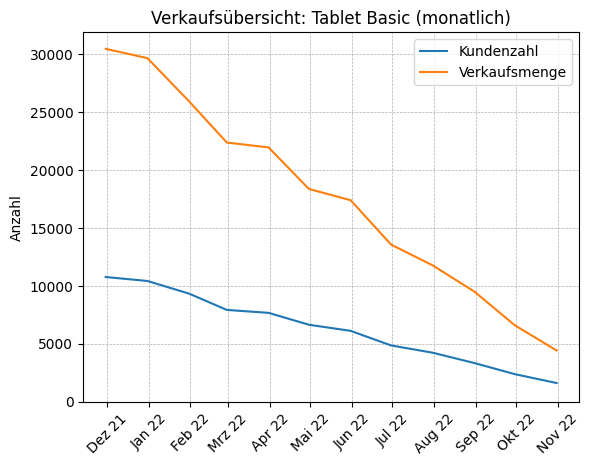

In [18]:
sns.lineplot(data=sum_stats_per_week, x="date", y="transaction_id", label="Kundenzahl")
sns.lineplot(data=sum_stats_per_week, x="date", y="amount", label="Verkaufsmenge")

format_lineplot()
plt.title("Verkaufsübersicht: Tablet Basic (monatlich)")
plt.gca().set_ylabel("Anzahl")

plt.show()

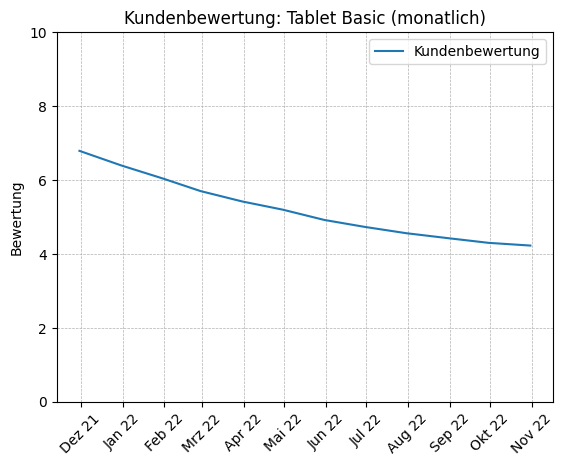

In [19]:
sns.lineplot(data=sum_stats_per_week, x="date", y="customer_rating", label="Kundenbewertung")

format_lineplot()
plt.title("Kundenbewertung: Tablet Basic (monatlich)")
plt.gca().set_ylabel("Bewertung")
plt.gca().set_ylim(top=10)

plt.show()

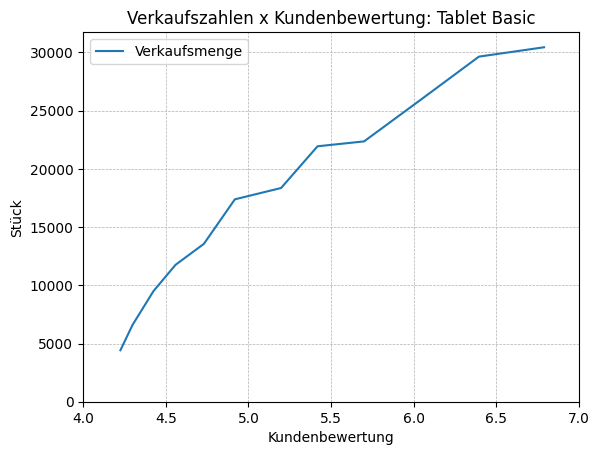

In [20]:
sns.lineplot(data=sum_stats_per_week, x="customer_rating", y="amount", label="Verkaufsmenge")
plt.title("Verkaufszahlen x Kundenbewertung: Tablet Basic")
plt.gca().set_ylabel("Stück")
plt.gca().set_xlabel("Kundenbewertung")
plt.gca().set_ylim(bottom=0)
plt.gca().set_xlim(left=4, right=7)
plt.grid(which="both", axis="both", linestyle="--", linewidth=0.5)

plt.show()

[Text(0.5, 1.0, 'Durschnittliche Basic Tablet Anzahl pro Transaktion (Wochendurchschnitte)'),
 Text(0.5, 0, 'Datum'),
 Text(0, 0.5, 'Stück')]

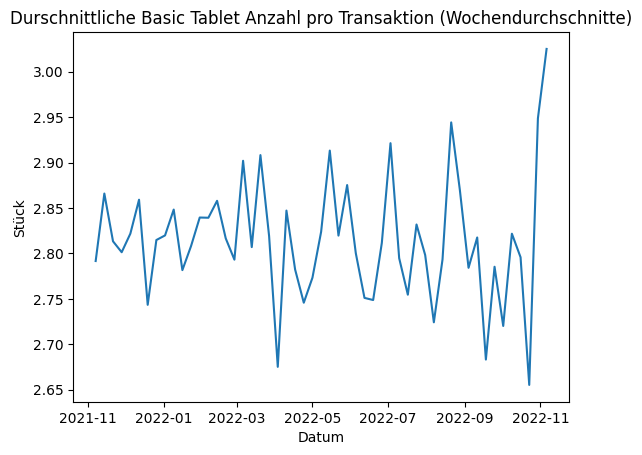

In [21]:
ax = sns.lineplot(data=stats_per_week, x="date", y="amount")
ax.set(title="Durschnittliche Basic Tablet Anzahl pro Transaktion (Wochendurchschnitte)", xlabel="Datum", ylabel="Stück")

[Text(0.5, 1.0, 'Anzahl der Transaktionen von Basic Tablets pro Woche'),
 Text(0.5, 0, 'Datum'),
 Text(0, 0.5, 'Transaktionen')]

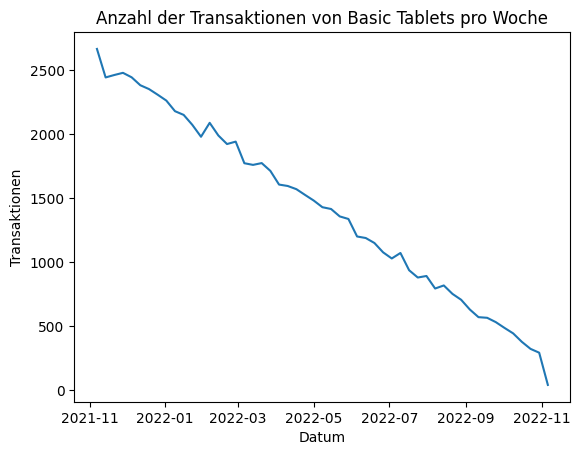

In [22]:
ax = sns.lineplot(data=stats_per_week, x="date", y="transaction_id")
ax.set(title="Anzahl der Transaktionen von Basic Tablets pro Woche", xlabel="Datum", ylabel="Transaktionen")

[Text(0.5, 1.0, 'Verkaufte Basic Tablets pro Woche'),
 Text(0.5, 0, 'Datum'),
 Text(0, 0.5, 'Stück')]

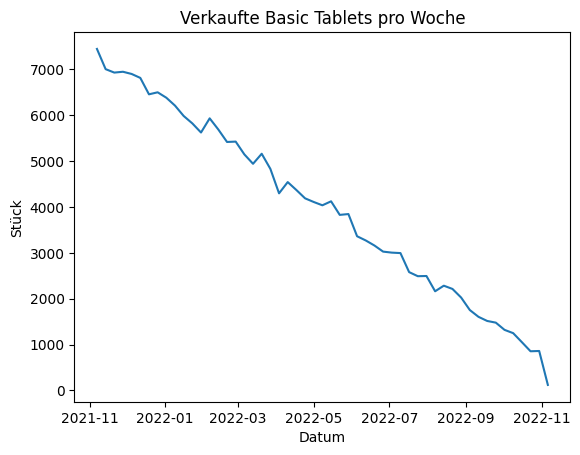

In [23]:
stats_per_week = df_basic.groupby(pd.Grouper(key="date",freq="1W")).agg({"transaction_id": "count", "price": "median", "cost_per_unit": "mean", "profit_per_unit": "mean", "revenue": "mean", "amount": "sum"})

ax = sns.lineplot(data=stats_per_week, x="date", y="amount")
ax.set(title="Verkaufte Basic Tablets pro Woche", xlabel="Datum", ylabel="Stück")

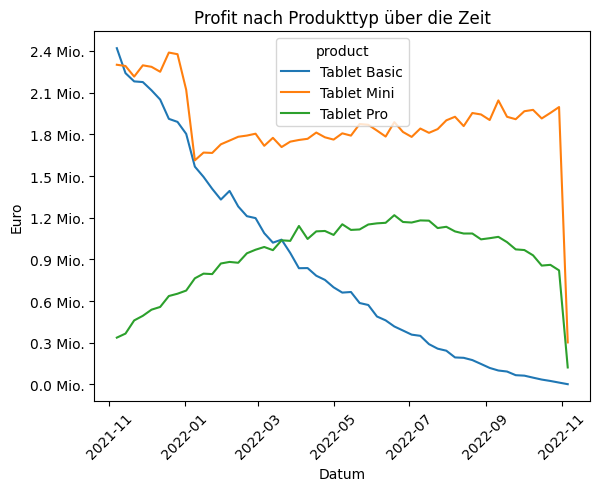

In [24]:
profit_by_type = df_reg_main.groupby(["product", pd.Grouper(key="date", freq="1W")]).agg({"profit": "sum"})

ax = sns.lineplot(data=profit_by_type, x="date", y="profit", hue="product")
ax.set(title='Profit nach Produkttyp über die Zeit', xlabel="Datum", ylabel="Euro")

def format_y_axis_millions(value, _):
    return f'{value / 1e6:.1f} Mio.'
ax.yaxis.set_major_formatter(FuncFormatter(format_y_axis_millions))
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.xticks(rotation=45)

plt.show()

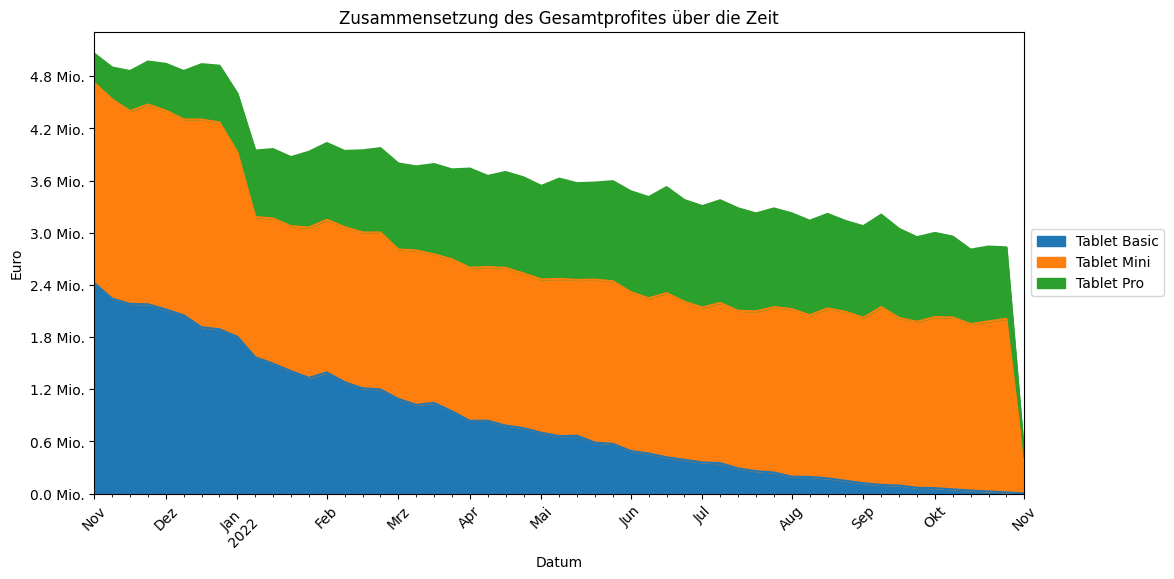

In [25]:
profit_by_type = df_reg_main.groupby(["product", pd.Grouper(key="date", freq="1W")]).agg({"profit": "sum"}).reset_index()
df_pivot = profit_by_type.pivot(index="date", columns="product", values="profit")

# Erstelle das gestapelte Flächendiagramm
ax = df_pivot.plot.area(stacked=True, figsize=(12, 6))

# Optional: Drehung der x-Achsenbeschriftungen für bessere Lesbarkeit
plt.xticks(rotation=45)

# Optional: Legende außerhalb des Plots positionieren
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Funktion zur Formatierung der y-Achsenticklabels
def format_y_axis(value, _):
    # Teile den Wert durch 1 Million und formatiere als Millionen mit einem Dezimalplatz
    return f'{value / 1e6:.1f} Mio.'

# Setze die benutzerdefinierte Formatierung auf der y-Achse
ax.yaxis.set_major_formatter(FuncFormatter(format_y_axis))

# Ändere die Einheiten auf der y-Achse direkt
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True)) 
ax.set(title='Zusammensetzung des Gesamtprofites über die Zeit', xlabel="Datum", ylabel="Euro")


# Diagramm anzeigen
plt.show()

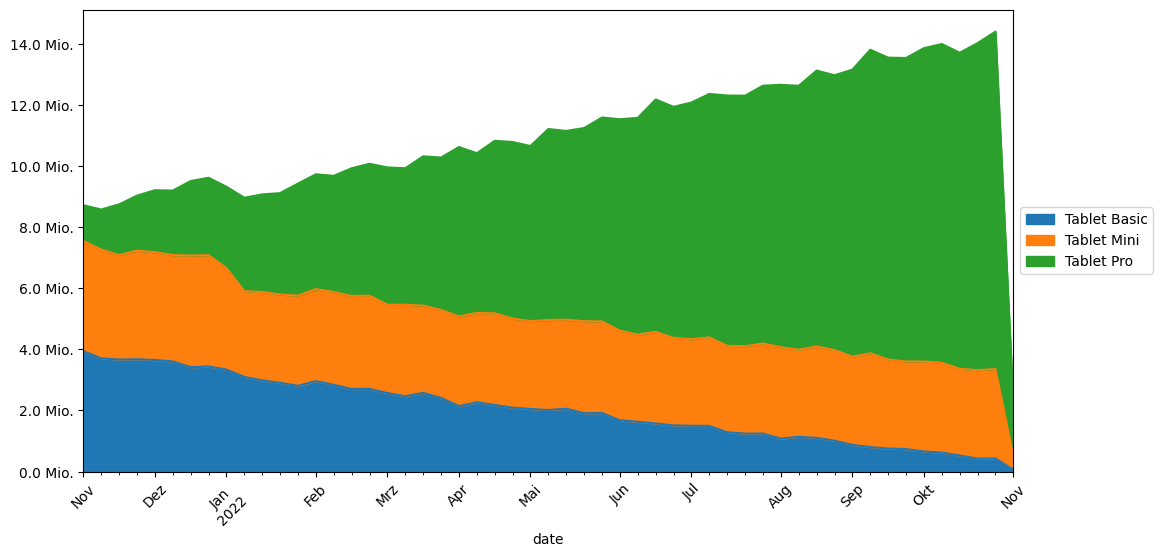

In [26]:
rev_by_type = df_reg_main.groupby(["product", pd.Grouper(key="date", freq="1W")]).agg({"revenue": "sum"}).reset_index()
df_pivot = rev_by_type.pivot(index="date", columns="product", values="revenue")

# Erstelle das gestapelte Flächendiagramm
ax = df_pivot.plot.area(stacked=True, figsize=(12, 6))

# Optional: Drehung der x-Achsenbeschriftungen für bessere Lesbarkeit
plt.xticks(rotation=45)

# Optional: Legende außerhalb des Plots positionieren
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Funktion zur Formatierung der y-Achsenticklabels
def format_y_axis(value, _):
    # Teile den Wert durch 1 Million und formatiere als Millionen mit einem Dezimalplatz
    return f'{value / 1e6:.1f} Mio.'

# Setze die benutzerdefinierte Formatierung auf der y-Achse
ax.yaxis.set_major_formatter(FuncFormatter(format_y_axis))

# Ändere die Einheiten auf der y-Achse direkt
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True)) 

# Diagramm anzeigen
plt.show()

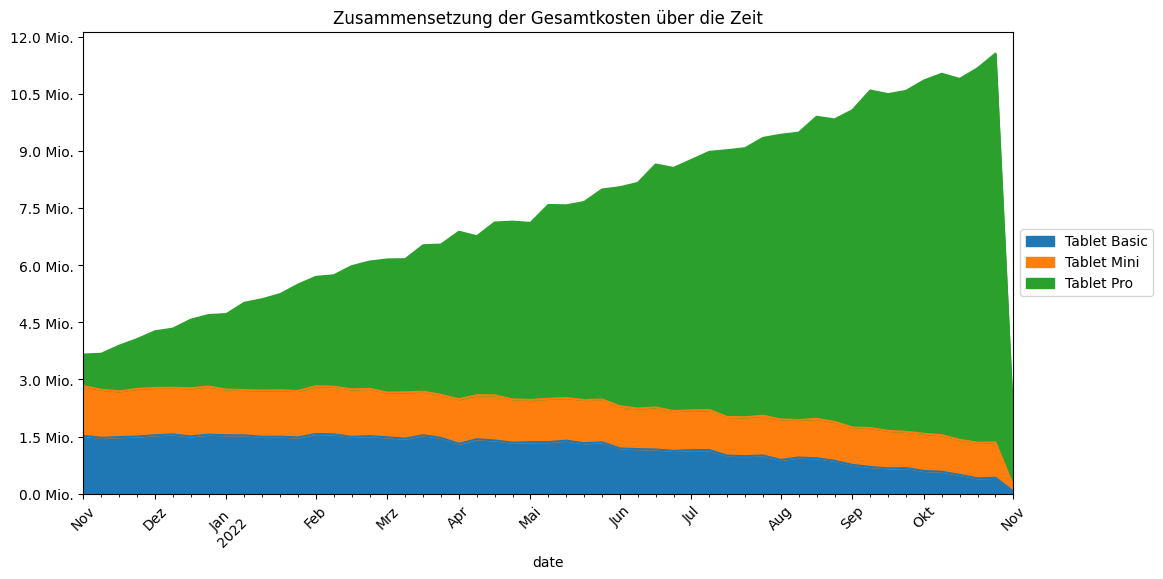

In [27]:
cost_by_type = df_reg_main.groupby(["product", pd.Grouper(key="date", freq="1W")]).agg({"cost": "sum"}).reset_index()
df_pivot = cost_by_type.pivot(index="date", columns="product", values="cost")

# Erstelle das gestapelte Flächendiagramm
ax = df_pivot.plot.area(stacked=True, figsize=(12, 6))

# Optional: Drehung der x-Achsenbeschriftungen für bessere Lesbarkeit
plt.xticks(rotation=45)

# Optional: Legende außerhalb des Plots positionieren
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Funktion zur Formatierung der y-Achsenticklabels
def format_y_axis(value, _):
    # Teile den Wert durch 1 Million und formatiere als Millionen mit einem Dezimalplatz
    return f'{value / 1e6:.1f} Mio.'

# Setze die benutzerdefinierte Formatierung auf der y-Achse
ax.yaxis.set_major_formatter(FuncFormatter(format_y_axis))

# Ändere die Einheiten auf der y-Achse direkt
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True)) 
ax.set_title('Zusammensetzung der Gesamtkosten über die Zeit')

# Diagramm anzeigen
plt.show()

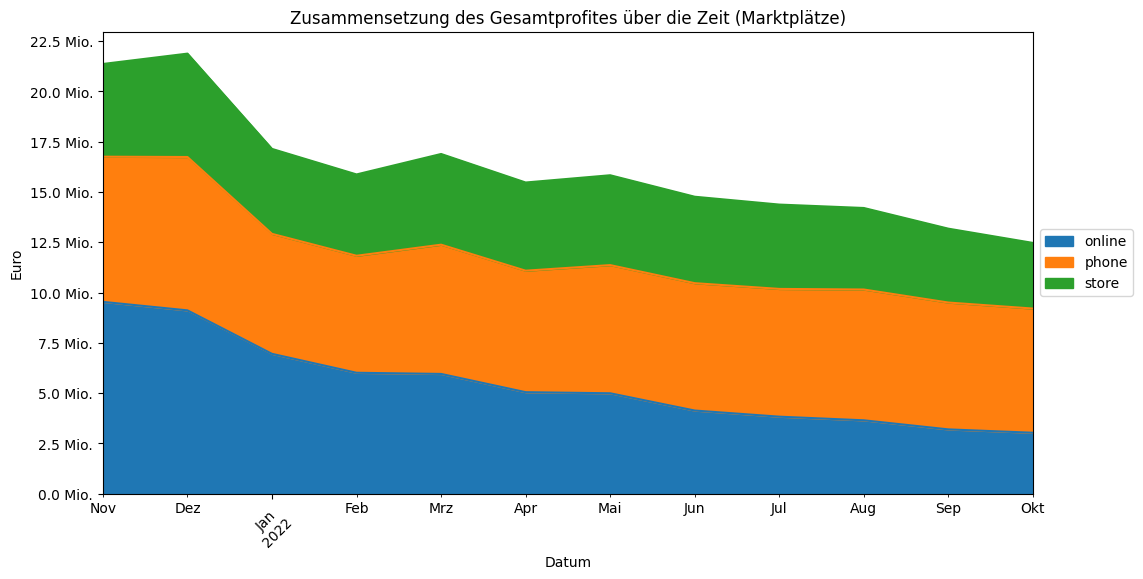

In [28]:
profit_by_type = df_reg_main.groupby(["marketplace", pd.Grouper(key="date", freq="1M")]).agg({"profit": "sum"}).reset_index()
df_pivot = profit_by_type.pivot(index="date", columns="marketplace", values="profit")

# Erstelle das gestapelte Flächendiagramm
ax = df_pivot.plot.area(stacked=True, figsize=(12, 6))

# Optional: Drehung der x-Achsenbeschriftungen für bessere Lesbarkeit
plt.xticks(rotation=45)

# Optional: Legende außerhalb des Plots positionieren
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Funktion zur Formatierung der y-Achsenticklabels
def format_y_axis(value, _):
    # Teile den Wert durch 1 Million und formatiere als Millionen mit einem Dezimalplatz
    return f'{value / 1e6:.1f} Mio.'

# Setze die benutzerdefinierte Formatierung auf der y-Achse
ax.yaxis.set_major_formatter(FuncFormatter(format_y_axis))

# Ändere die Einheiten auf der y-Achse direkt
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True)) 
ax.set(title='Zusammensetzung des Gesamtprofites über die Zeit (Marktplätze)', xlabel="Datum", ylabel="Euro")


# Diagramm anzeigen
plt.show()

<Axes: xlabel='date', ylabel='profit'>

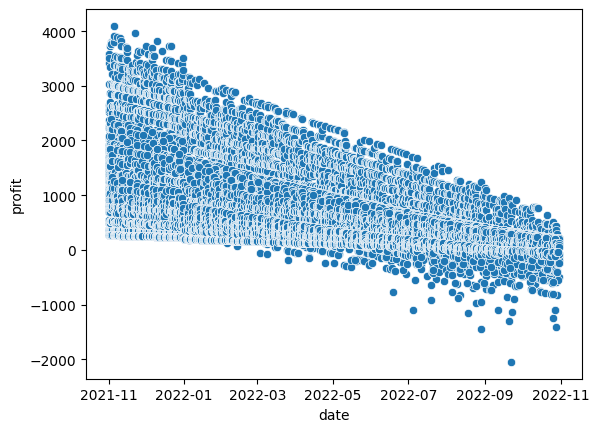

In [29]:
sns.scatterplot(data=df_basic, y="profit", x="date")

<Axes: xlabel='marketplace', ylabel='profit_per_unit'>

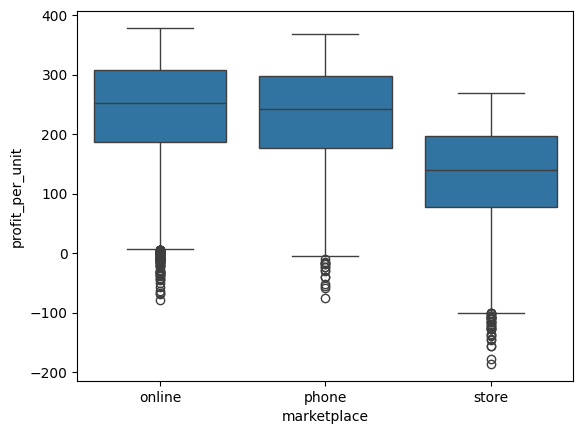

In [30]:
sns.boxplot(data=df_basic, y="profit_per_unit", x="marketplace")

In [31]:
df_basic_loss = df_basic[df_basic["profit"] <= 0]
df_basic_win = df_basic[df_basic["profit"] > 0]

In [32]:
df_basic_loss

,date,product,discount,amount,basic,mini,pro,cost_basic,cost_mini,cost_pro,...,week,cost_per_unit,cost,price,revenue,profit_per_unit,profit,customer_rating,region,marketplace
4918,2022-08-22,Tablet Basic,0.9,14,1,0,0,548.41,NaN,NaN,...,34,548.41,7677.74,499,6986,-49.41,-691.74,5.6,A,online
5091,2022-09-29,Tablet Basic,0.9,8,1,0,0,521.40,NaN,NaN,...,39,521.40,4171.20,499,3992,-22.40,-179.20,3.4,A,online
5092,2022-09-29,Tablet Basic,0.9,7,1,0,0,501.44,NaN,NaN,...,39,501.44,3510.08,499,3493,-2.44,-17.08,6.4,A,online
5140,2022-10-11,Tablet Basic,0.9,13,1,0,0,532.15,NaN,NaN,...,41,532.15,6917.95,499,6487,-33.15,-430.95,4.4,A,online
5171,2022-10-23,Tablet Basic,0.9,8,1,0,0,502.58,NaN,NaN,...,42,502.58,4020.64,499,3992,-3.58,-28.64,5.1,A,online
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292429,2022-10-27,Tablet Basic,0.9,3,1,0,0,535.74,NaN,NaN,...,43,535.74,1607.22,499,1497,-36.74,-110.22,4.4,D,store
292430,2022-10-27,Tablet Basic,0.9,7,1,0,0,655.75,NaN,NaN,...,43,655.75,4590.25,499,3493,-156.75,-1097.25,2.9,D,store
292431,2022-10-29,Tablet Basic,1.0,1,1,0,0,537.91,NaN,NaN,...,43,537.91,537.91,499,499,-38.91,-38.91,4.2,D,store
292432,2022-10-29,Tablet Basic,1.0,1,1,0,0,537.93,NaN,NaN,...,43,537.93,537.93,499,499,-38.93,-38.93,4.9,D,store


In [33]:
df_basic_loss[df_basic_loss["discount"] != 1]

,date,product,discount,amount,basic,mini,pro,cost_basic,cost_mini,cost_pro,...,week,cost_per_unit,cost,price,revenue,profit_per_unit,profit,customer_rating,region,marketplace
4918,2022-08-22,Tablet Basic,0.9,14,1,0,0,548.41,NaN,NaN,...,34,548.41,7677.74,499,6986,-49.41,-691.74,5.6,A,online
5091,2022-09-29,Tablet Basic,0.9,8,1,0,0,521.40,NaN,NaN,...,39,521.40,4171.20,499,3992,-22.40,-179.20,3.4,A,online
5092,2022-09-29,Tablet Basic,0.9,7,1,0,0,501.44,NaN,NaN,...,39,501.44,3510.08,499,3493,-2.44,-17.08,6.4,A,online
5140,2022-10-11,Tablet Basic,0.9,13,1,0,0,532.15,NaN,NaN,...,41,532.15,6917.95,499,6487,-33.15,-430.95,4.4,A,online
5171,2022-10-23,Tablet Basic,0.9,8,1,0,0,502.58,NaN,NaN,...,42,502.58,4020.64,499,3992,-3.58,-28.64,5.1,A,online
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292421,2022-10-23,Tablet Basic,0.9,3,1,0,0,572.58,NaN,NaN,...,42,572.58,1717.74,499,1497,-73.58,-220.74,4.3,D,store
292423,2022-10-24,Tablet Basic,0.9,7,1,0,0,613.53,NaN,NaN,...,43,613.53,4294.71,499,3493,-114.53,-801.71,4.6,D,store
292428,2022-10-26,Tablet Basic,0.9,5,1,0,0,615.08,NaN,NaN,...,43,615.08,3075.40,499,2495,-116.08,-580.40,4.0,D,store
292429,2022-10-27,Tablet Basic,0.9,3,1,0,0,535.74,NaN,NaN,...,43,535.74,1607.22,499,1497,-36.74,-110.22,4.4,D,store


In [66]:
df_basic_loss_agg = df_basic_loss.groupby(["marketplace", "region"]).agg({"transaction_id": "count", "cost_per_unit": "mean", "profit": "mean"})

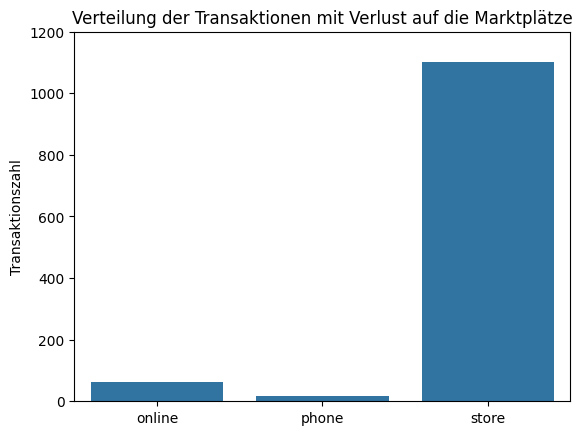

In [68]:
df_basic_loss_markets = df_basic_loss.groupby("marketplace").agg({"transaction_id": "count"})
ax = sns.barplot(data=df_basic_loss_markets, x="marketplace", y="transaction_id")
ax.set(title="Verteilung der Transaktionen mit Verlust auf die Marktplätze", xlabel="Marktplatz", ylabel="Transaktionszahl")

locale.setlocale(locale.LC_TIME, "de_DE.utf8")

# Create a MonthLocator object to ensure ticks are set at monthly intervals
#locator = mdates.MonthLocator()

# Set the locator for the x-axis
#plt.gca().xaxis.set_major_locator(locator)

# Format x-axis with German months in abbreviated form and year
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))

# Optionally, set the x-tick labels rotation
#plt.xticks(rotation=45)

# Set the starting point of the y-axis to 0
plt.gca().set_ylim(bottom=0, top=1200)

# Remove the y-axis and x-axis label
plt.gca().set_ylabel("Transaktionszahl")
plt.gca().set_xlabel("")

# Add grid lines for better readability
#plt.grid(which="both", axis="both", linestyle="--", linewidth=0.5)

plt.show()

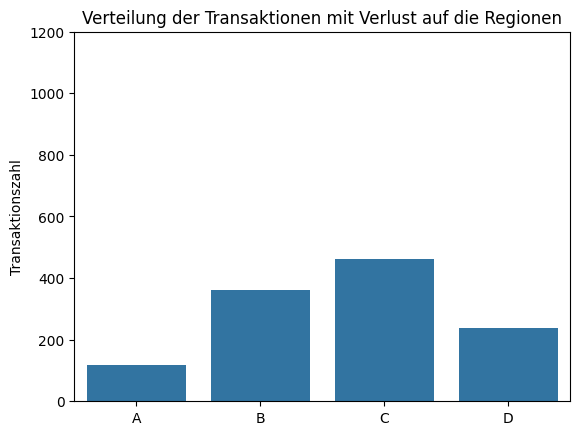

In [65]:
df_basic_loss_regions = df_basic_loss.groupby("region").agg({"transaction_id": "count"})
ax = sns.barplot(data=df_basic_loss_regions, x="region", y="transaction_id")
ax.set(title="Verteilung der Transaktionen mit Verlust auf die Regionen", xlabel="Marktplatz", ylabel="Transaktionszahl")

# Set the starting point of the y-axis to 0
plt.gca().set_ylim(bottom=0, top=1200)

# Remove the y-axis and x-axis label
plt.gca().set_ylabel("Transaktionszahl")
plt.gca().set_xlabel("")

plt.show()


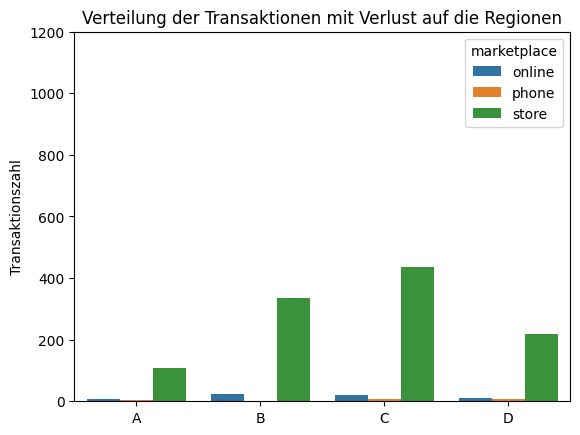

In [76]:
ax = sns.barplot(data=df_basic_loss_agg, x="region", y="transaction_id", hue="marketplace")
ax.set(title="Verteilung der Transaktionen mit Verlust auf die Regionen", xlabel="Marktplatz", ylabel="Transaktionszahl")

# Set the starting point of the y-axis to 0
plt.gca().set_ylim(bottom=0, top=1200)

# Remove the y-axis and x-axis label
plt.gca().set_ylabel("Transaktionszahl")
plt.gca().set_xlabel("")

plt.show()

<Axes: xlabel='date', ylabel='transaction_id'>

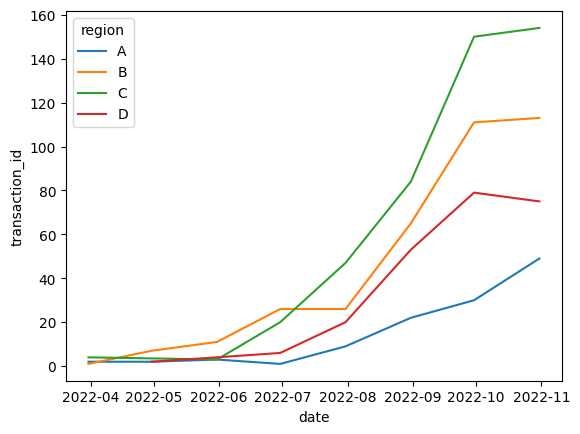

In [79]:
df_basic_loss_regions = df_basic_loss.groupby(["region", pd.Grouper(key="date", freq="1M")]).agg({"transaction_id": "count"})
sns.lineplot(data=df_basic_loss_regions, x="date", y="transaction_id", hue="region")

<Axes: xlabel='date', ylabel='transaction_id'>

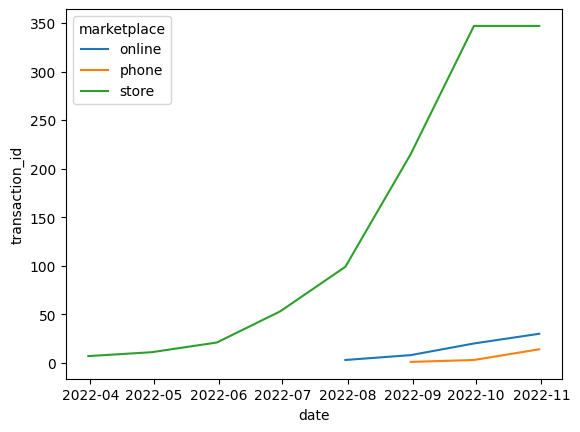

In [95]:
df_basic_loss_regions = df_basic_loss.groupby(["marketplace", pd.Grouper(key="date", freq="1M")]).agg({"transaction_id": "count"})
sns.lineplot(data=df_basic_loss_regions, x="date", y="transaction_id", hue="marketplace")

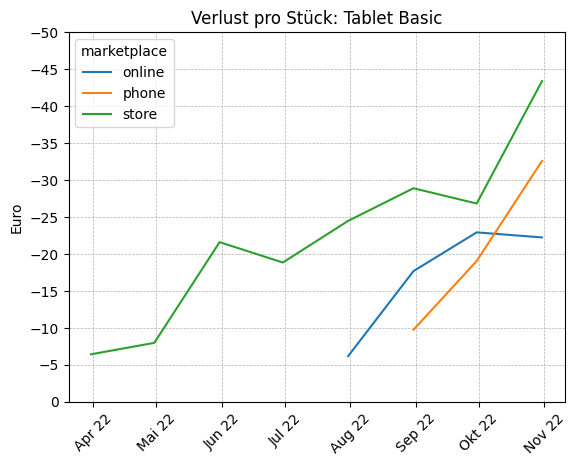

In [111]:
df_basic_loss_regions = df_basic_loss.groupby(["marketplace", pd.Grouper(key="date", freq="1M")]).agg({"profit_per_unit": "mean"})
sns.lineplot(data=df_basic_loss_regions, x="date", y="profit_per_unit", hue="marketplace")

locale.setlocale(locale.LC_TIME, "de_DE.utf8")

# Create a MonthLocator object to ensure ticks are set at monthly intervals
locator = mdates.MonthLocator()

# Set the locator for the x-axis
plt.gca().xaxis.set_major_locator(locator)

# Format x-axis with German months in abbreviated form and year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))

# Optionally, set the x-tick labels rotation
plt.xticks(rotation=45)

# Set the starting point of the y-axis to 0
plt.gca().set_ylim(top=0)
plt.gca().set_yticks(ticks=[0,-5,-10,-15,-20,-25,-30,-35,-40,-45,-50])

# Remove the y-axis and x-axis label
plt.gca().set_ylabel("Euro")
plt.gca().set_xlabel("")
plt.gca().set_title("Verlust pro Stück: Tablet Basic")

# Add grid lines for better readability
plt.grid(which="both", axis="both", linestyle="--", linewidth=0.5)

plt.gca().invert_yaxis()

plt.show()

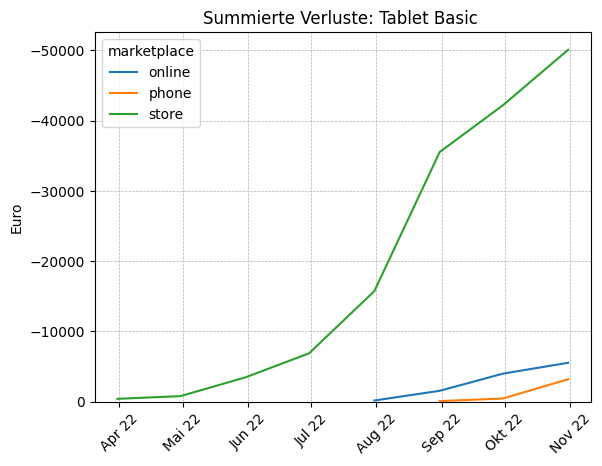

In [110]:
df_basic_loss_regions = df_basic_loss.groupby(["marketplace", pd.Grouper(key="date", freq="1M")]).agg({"profit": "sum"})
sns.lineplot(data=df_basic_loss_regions, x="date", y="profit", hue="marketplace")

locale.setlocale(locale.LC_TIME, "de_DE.utf8")

# Create a MonthLocator object to ensure ticks are set at monthly intervals
locator = mdates.MonthLocator()

# Set the locator for the x-axis
plt.gca().xaxis.set_major_locator(locator)

# Format x-axis with German months in abbreviated form and year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))

# Optionally, set the x-tick labels rotation
plt.xticks(rotation=45)

# Set the starting point of the y-axis to 0
plt.gca().set_ylim(top=0)

# Remove the y-axis and x-axis label
plt.gca().set_ylabel("Euro")
plt.gca().set_title("Summierte Verluste: Tablet Basic ")
plt.gca().set_xlabel("")

# Add grid lines for better readability
plt.grid(which="both", axis="both", linestyle="--", linewidth=0.5)

plt.gca().invert_yaxis()

plt.show()

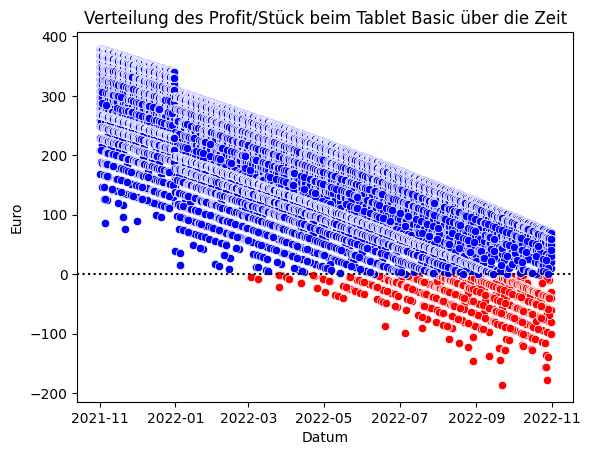

In [36]:
ax = sns.scatterplot(data=df_basic_loss, y="profit_per_unit", x="date", color="red")
ax = sns.scatterplot(data=df_basic_win, y="profit_per_unit", x="date", color="blue")
ax.set(title="Verteilung des Profit/Stück beim Tablet Basic über die Zeit", xlabel="Datum", ylabel="Euro")
ax.axhline(y=0, color="black", ls=":")

plt.show()

In [37]:
stats_basic_by_region = df_basic.groupby(["region", pd.Grouper(key="date", freq="1W")]).agg({"cost_per_unit": "mean", "profit_per_unit": "mean", "transaction_id": "count", "amount": "sum"})
stats_basic_by_market = df_basic.groupby(["marketplace", pd.Grouper(key="date", freq="1W")]).agg({"cost_per_unit": "mean", "profit_per_unit": "mean", "transaction_id": "count", "amount": "sum"})

<Axes: xlabel='date', ylabel='cost_per_unit'>

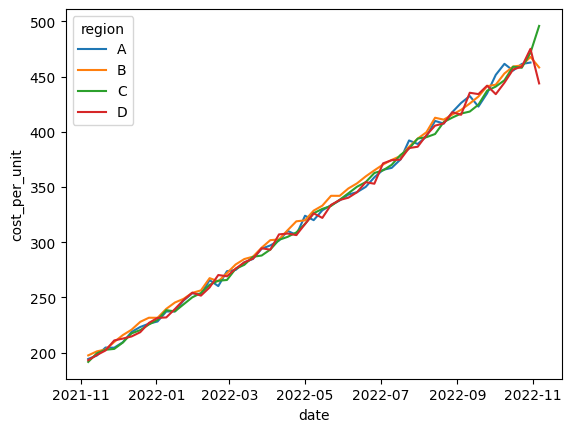

In [38]:
sns.lineplot(data=stats_basic_by_region, x="date", y="cost_per_unit", hue="region")

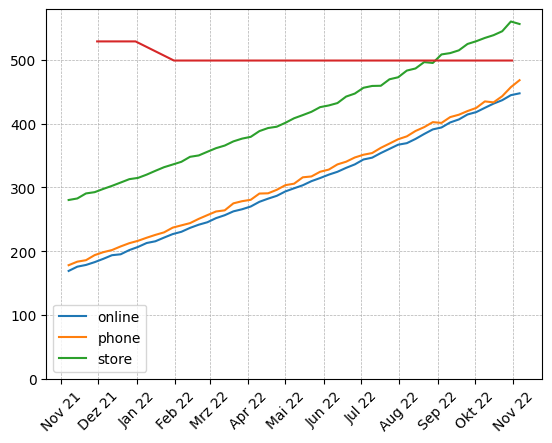

In [57]:
sns.lineplot(data=stats_basic_by_market, x="date", y="cost_per_unit", hue="marketplace")
sns.lineplot(data=stats_per_week, x="date", y="price")

format_lineplot()


plt.show()


<Axes: xlabel='date', ylabel='transaction_id'>

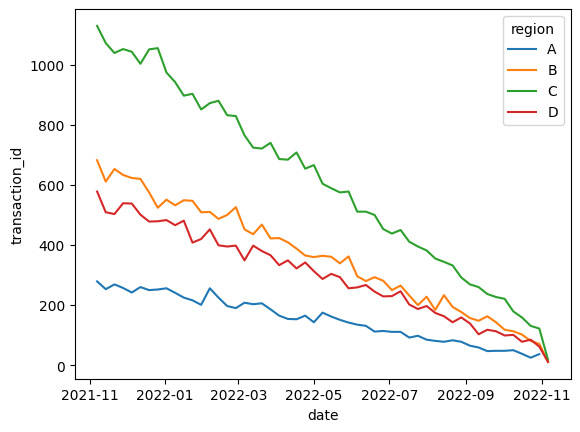

In [40]:
sns.lineplot(data=stats_basic_by_region, x="date", y="transaction_id", hue="region")

<Axes: xlabel='date', ylabel='transaction_id'>

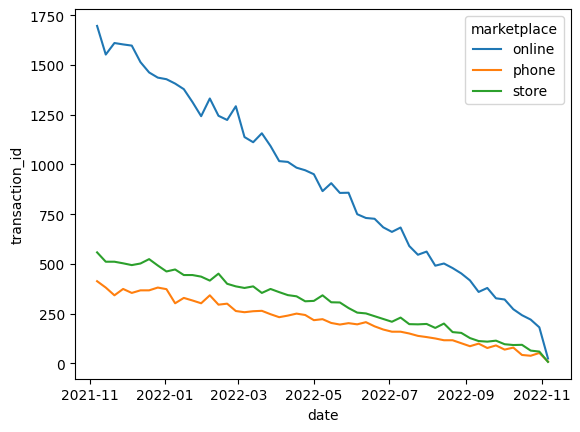

In [41]:
sns.lineplot(data=stats_basic_by_market, x="date", y="transaction_id", hue="marketplace")


<Axes: xlabel='date', ylabel='amount'>

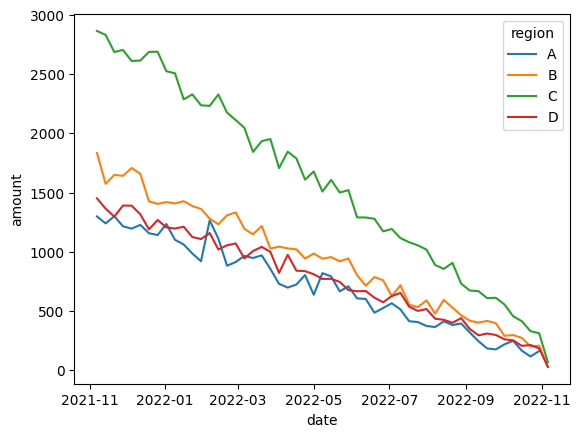

In [42]:
sns.lineplot(data=stats_basic_by_region, x="date", y="amount", hue="region")


<Axes: xlabel='date', ylabel='amount'>

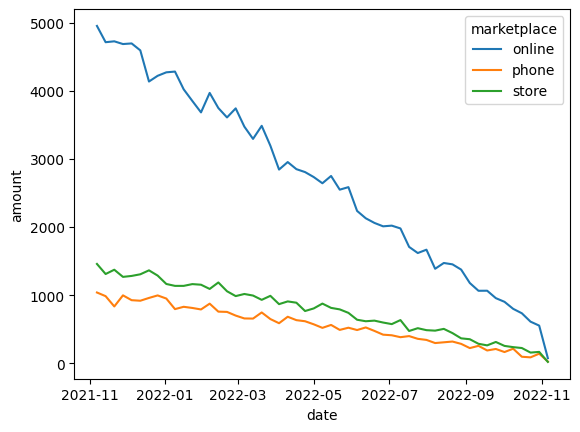

In [43]:
sns.lineplot(data=stats_basic_by_market, x="date", y="amount", hue="marketplace")


# Modelle für Gesamtdaten

In [44]:
model_basic_profit = smf.ols("profit_per_unit ~ price + cost_per_unit", data=df_basic).fit()
model_basic_profit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        profit_per_unit   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.339e+30
Date:                 So, 17 Dez 2023   Prob (F-statistic):               0.00
Time:                        22:57:30   Log-Likelihood:             1.7988e+06
No. Observations:               75253   AIC:                        -3.598e+06
Df Residuals:                   75250   BIC:                        -3.597e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      6.946e-11   1.72e-12     40.333      0.000    6.61e-11    7.28e-11
price             1.0000   3.23e-15   3.09e+14      0.000       1.000       1.000
cost_per_unit    -1.0000   5.02e-16  -1.99e+15      0.000      -1.000      -1.000
==============================================================================
Omnibus:                    31981.657   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15327.779
Skew:                           0.972   Prob(JB):                         0.00
Kurtosis:                       1.946   Cond. No.                     2.74e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.74e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [45]:
model_basic_cost = smf.ols("cost_per_unit ~ discount + amount + marketplace + region", data=df_basic).fit()
model_basic_cost.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          cost_per_unit   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     5099.
Date:                 So, 17 Dez 2023   Prob (F-statistic):               0.00
Time:                        22:57:30   Log-Likelihood:            -4.1521e+05
No. Observations:               73001   AIC:                         8.304e+05
Df Residuals:                   72993   BIC:                         8.305e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              391.3068      6.675     58.622      0.000     378.224     404.390
marketplace[T.phone]    14.4424      0.850     16.985      0.000      12.776      16.109
marketplace[T.store]   113.9607      0.656    173.768      0.000     112.675     115.246
region[T.B]             21.2163      1.032     20.564      0.000      19.194      23.238
region[T.C]             20.1903      0.958     21.086      0.000      18.314      22.067
region[T.D]             20.4549      1.072     19.073      0.000      18.353      22.557
discount              -181.5184      6.406    -28.334      0.000    -194.075    -168.962
amount                   9.3290      0.168     55.617      0.000       9.000       9.658
==============================================================================
Omnibus:                     4873.926   Durbin-Watson:                   0.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5159.153
Skew:                           0.614   Prob(JB):                         0.00
Kurtosis:                       2.566   Cond. No.                         127.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
model_basic_profit = smf.ols("profit ~ amount + profit_per_unit + customer_rating + customer_rating:amount + cost_per_unit + price:profit_per_unit:cost_per_unit", data=df_basic).fit()
model_basic_profit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                 1.030e+05
Date:                 So, 17 Dez 2023   Prob (F-statistic):               0.00
Time:                        22:57:30   Log-Likelihood:            -4.8663e+05
No. Observations:               75253   AIC:                         9.733e+05
Df Residuals:                   75246   BIC:                         9.733e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                            -128.2414     27.837     -4.607      0.000    -182.802     -73.681
amount                                 18.8747      1.343     14.058      0.000      16.243      21.506
profit_per_unit                         2.1351      0.053     40.585      0.000       2.032       2.238
customer_rating                       -98.2524      0.836   -117.482      0.000     -99.892     -96.613
customer_rating:amount                 33.2178      0.234    141.798      0.000      32.759      33.677
cost_per_unit                          -0.1765      0.057     -3.104      0.002      -0.288      -0.065
price:profit_per_unit:cost_per_unit  9.749e-06   1.27e-07     76.843      0.000     9.5e-06       1e-05
==============================================================================
Omnibus:                    18125.782   Durbin-Watson:                   1.468
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           632782.544
Skew:                          -0.464   Prob(JB):                         0.00
Kurtosis:                      17.176   Cond. No.                     1.43e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.43e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [47]:
model_basic_profit = smf.ols("amount ~ customer_rating", data=df_basic).fit()
model_basic_profit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 amount   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.047
Date:                 So, 17 Dez 2023   Prob (F-statistic):              0.306
Time:                        22:57:30   Log-Likelihood:            -1.5385e+05
No. Observations:               75253   AIC:                         3.077e+05
Df Residuals:                   75251   BIC:                         3.077e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.7856      0.030     93.644      0.000       2.727       2.844
customer_rating     0.0053      0.005      1.023      0.306      -0.005       0.015
==============================================================================
Omnibus:                    21458.201   Durbin-Watson:                   1.481
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            58802.815
Skew:                           1.529   Prob(JB):                         0.00
Kurtosis:                       6.067   Cond. No.                         25.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Modelle für wöchentliche Daten

In [48]:
stats_per_week = df_basic.groupby(pd.Grouper(key="date",freq="1W")).agg({"transaction_id": "count", "price": "mean", "cost_per_unit": "mean", "profit_per_unit": "mean", "revenue": "mean", "amount": "sum", "customer_rating": "mean", "profit": "sum"})
stats_per_week_mini = df_mini.groupby(pd.Grouper(key="date",freq="1W")).agg({"transaction_id": "count", "price": "mean", "cost_per_unit": "mean", "profit_per_unit": "mean", "revenue": "mean", "amount": "sum", "customer_rating": "mean", "profit": "sum"})
stats_per_week_pro = df_pro.groupby(pd.Grouper(key="date",freq="1W")).agg({"transaction_id": "count", "price": "mean", "cost_per_unit": "mean", "profit_per_unit": "mean", "revenue": "mean", "amount": "sum", "customer_rating": "mean", "profit": "sum"})


stats_per_week

,transaction_id,price,cost_per_unit,profit_per_unit,revenue,amount,customer_rating,profit
date,,,,,,,,
2021-11-07,2668,529.000000,193.623066,335.376934,1476.758621,7448,6.931072,2420574.66
2021-11-14,2445,529.000000,199.229501,329.770499,1516.033947,7007,6.832720,2240926.38
2021-11-21,2464,529.000000,202.651627,326.348373,1488.241883,6932,6.767045,2181573.41
2021-11-28,2481,529.000000,206.669895,322.330105,1481.882306,6950,6.662072,2176697.69
2021-12-05,2446,529.000000,211.618528,317.381472,1492.705642,6902,6.567825,2117436.82
2021-12-12,2384,529.000000,217.789790,311.210210,1512.442953,6816,6.470680,2050721.16
2021-12-19,2354,529.000000,222.051534,306.948466,1451.266780,6458,6.400085,1911909.71
2021-12-26,2310,529.000000,227.162494,301.837506,1488.986147,6502,6.284199,1889975.15
2022-01-02,2264,520.519435,230.283454,290.235981,1474.256184,6384,6.242712,1803680.61


<Axes: xlabel='customer_rating', ylabel='transaction_id'>

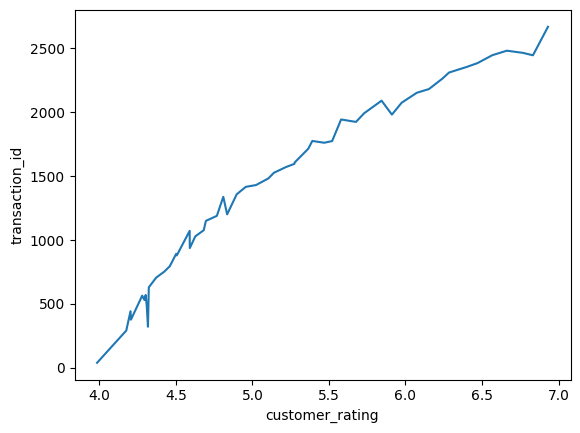

In [49]:
sns.lineplot(data=stats_per_week, x="customer_rating", y="transaction_id")

In [50]:
# Modell Kundenanzahl
model_basic_per_week = smf.ols("transaction_id ~ customer_rating", data=stats_per_week).fit()
model_basic_per_week.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         transaction_id   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     995.8
Date:                 So, 17 Dez 2023   Prob (F-statistic):           3.92e-35
Time:                        22:57:31   Log-Likelihood:                -342.53
No. Observations:                  53   AIC:                             689.1
Df Residuals:                      51   BIC:                             693.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -2873.4435    137.773    -20.856      0.000   -3150.035   -2596.852
customer_rating   826.0514     26.177     31.556      0.000     773.499     878.604
==============================================================================
Omnibus:                        4.574   Durbin-Watson:                   0.178
Prob(Omnibus):                  0.102   Jarque-Bera (JB):                4.451
Skew:                          -0.694   Prob(JB):                        0.108
Kurtosis:                       2.704   Cond. No.                         34.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
# Modell Kundenanzahl
model_mini_per_week = smf.ols("transaction_id ~ customer_rating + price", data=stats_per_week_mini).fit()
model_mini_per_week.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         transaction_id   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     2.097
Date:                 So, 17 Dez 2023   Prob (F-statistic):              0.133
Time:                        22:57:31   Log-Likelihood:                -365.44
No. Observations:                  53   AIC:                             736.9
Df Residuals:                      50   BIC:                             742.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1203.8273    573.281      2.100      0.041      52.358    2355.296
customer_rating   189.4388     92.653      2.045      0.046       3.340     375.537
price              -1.1273      0.926     -1.218      0.229      -2.987       0.732
==============================================================================
Omnibus:                      107.527   Durbin-Watson:                   1.125
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3718.581
Skew:                          -6.090   Prob(JB):                         0.00
Kurtosis:                      42.186   Cond. No.                     9.79e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.79e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [52]:
# Modell Kundenanzahl Pro
model_basic_per_week = smf.ols("transaction_id ~ customer_rating + price", data=stats_per_week_pro).fit()
model_basic_per_week.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         transaction_id   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     146.2
Date:                 So, 17 Dez 2023   Prob (F-statistic):           1.36e-16
Time:                        22:57:31   Log-Likelihood:                -422.16
No. Observations:                  53   AIC:                             848.3
Df Residuals:                      51   BIC:                             852.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0426      0.004    -11.332      0.000      -0.050      -0.035
customer_rating  5542.7712    458.437     12.091      0.000    4622.420    6463.122
price             -42.5780      3.757    -11.332      0.000     -50.121     -35.035
==============================================================================
Omnibus:                       88.813   Durbin-Watson:                   0.814
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1685.971
Skew:                          -4.668   Prob(JB):                         0.00
Kurtosis:                      29.006   Cond. No.                     1.34e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.94e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [53]:
# Modell Verkaufsmenge
model_basic_per_week = smf.ols("amount ~ customer_rating + price", data=stats_per_week).fit()
model_basic_per_week.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 amount   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     756.5
Date:                 So, 17 Dez 2023   Prob (F-statistic):           4.22e-38
Time:                        22:57:31   Log-Likelihood:                -386.44
No. Observations:                  53   AIC:                             778.9
Df Residuals:                      50   BIC:                             784.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        8759.9488   3159.516      2.773      0.008    2413.874    1.51e+04
customer_rating  2703.9098     91.886     29.427      0.000    2519.352    2888.468
price             -37.3382      6.951     -5.372      0.000     -51.299     -23.378
==============================================================================
Omnibus:                        2.766   Durbin-Watson:                   0.475
Prob(Omnibus):                  0.251   Jarque-Bera (JB):                2.485
Skew:                          -0.525   Prob(JB):                        0.289
Kurtosis:                       2.845   Cond. No.                     3.17e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.17e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [54]:
# Modell Profit
model_basic_per_week = smf.ols("profit ~ amount + price + customer_rating:amount + cost_per_unit", data=stats_per_week).fit()
model_basic_per_week.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.027e+04
Date:                 So, 17 Dez 2023   Prob (F-statistic):           1.01e-69
Time:                        22:57:31   Log-Likelihood:                -610.60
No. Observations:                  53   AIC:                             1231.
Df Residuals:                      48   BIC:                             1241.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -1.411e+06   4.19e+05     -3.364      0.002   -2.25e+06   -5.68e+05
amount                  -228.0202     28.753     -7.930      0.000    -285.833    -170.208
price                   3916.4917    692.176      5.658      0.000    2524.778    5308.205
customer_rating:amount    72.7916      2.622     27.765      0.000      67.520      78.063
cost_per_unit          -1336.7840    550.438     -2.429      0.019   -2443.513    -230.055
==============================================================================
Omnibus:                        6.073   Durbin-Watson:                   0.571
Prob(Omnibus):                  0.048   Jarque-Bera (JB):                4.995
Skew:                           0.659   Prob(JB):                       0.0823
Kurtosis:                       3.725   Cond. No.                     3.19e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.19e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [55]:
# Modell Profit
model_basic_per_week = smf.ols("profit ~ stats.zscore(amount) + stats.zscore(price) + stats.zscore(customer_rating):stats.zscore(amount) + stats.zscore(cost_per_unit)", data=stats_per_week).fit()
model_basic_per_week.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     7537.
Date:                 So, 17 Dez 2023   Prob (F-statistic):           1.69e-66
Time:                        22:57:31   Log-Likelihood:                -618.79
No. Observations:                  53   AIC:                             1248.
Df Residuals:                      48   BIC:                             1257.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                           6.664e+05   8577.748     77.685      0.000    6.49e+05    6.84e+05
stats.zscore(amount)                                3.935e+05    5.4e+04      7.290      0.000    2.85e+05    5.02e+05
stats.zscore(price)                                 3.846e+04   9073.298      4.239      0.000    2.02e+04    5.67e+04
stats.zscore(customer_rating):stats.zscore(amount)  1.817e+05   7727.247     23.516      0.000    1.66e+05    1.97e+05
stats.zscore(cost_per_unit)                        -2.446e+05   5.35e+04     -4.574      0.000   -3.52e+05   -1.37e+05
==============================================================================
Omnibus:                        2.254   Durbin-Watson:                   0.399
Prob(Omnibus):                  0.324   Jarque-Bera (JB):                1.391
Skew:                           0.332   Prob(JB):                        0.499
Kurtosis:                       3.436   Cond. No.                         31.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [56]:
# Modell Profit
model_basic_per_week = smf.ols("profit ~ amount + profit_per_unit + customer_rating:amount", data=stats_per_week).fit()
model_basic_per_week.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.166e+04
Date:                 So, 17 Dez 2023   Prob (F-statistic):           6.66e-70
Time:                        22:57:31   Log-Likelihood:                -615.40
No. Observations:                  53   AIC:                             1239.
Df Residuals:                      49   BIC:                             1247.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -1.156e+05   1.37e+04     -8.449      0.000   -1.43e+05   -8.81e+04
amount                  -299.8593     18.337    -16.353      0.000    -336.709    -263.010
profit_per_unit         2300.6617    491.503      4.681      0.000    1312.949    3288.374
customer_rating:amount    78.2127      2.111     37.044      0.000      73.970      82.456
==============================================================================
Omnibus:                        1.688   Durbin-Watson:                   0.755
Prob(Omnibus):                  0.430   Jarque-Bera (JB):                1.652
Skew:                           0.358   Prob(JB):                        0.438
Kurtosis:                       2.516   Cond. No.                     9.60e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.6e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""